In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

In [14]:

#df = pd.read_csv('../simple/processed_data/noacut/final/simple_noacut_final.csv', sep=',')
#cuts = spio.loadmat('../simple/processed_data/noacut/final/simple_noacut_final_cuts')['cuts']
#keep_index = np.nonzero((df.total_count >= 20) & ((df.seq.str.slice(50+20, 56+20) == 'AATAAA') | (df.seq.str.slice(50+20, 56+20) == 'ATTAAA')))[0]

df = pd.read_csv('../doubledope/processed_data/score_60/final/doubledope_score_60_final.csv', sep=',')
cuts = spio.loadmat('../doubledope/processed_data/score_60/final/doubledope_score_60_final_cuts')['cuts']
keep_index = np.nonzero(df.total_count >= 10)[0]

df = df.iloc[keep_index].copy()
cuts = cuts[keep_index, :]

print(len(df))

proximal_usage = (np.sum(cuts[:, 57+20:87+20], axis=1) + 0.1) / (np.sum(cuts, axis=1) + 2. * 0.1)

cuts = None

df['proximal_usage'] = proximal_usage
df['seq'] = df['seq'].str.slice(20, 186+20)

269717


In [ ]:
#Generate feature matrix

mer4_dict = {}
mer4_list = []
mer6_dict = {}
mer6_list = []
bases = list('ACGT')

#Build dictionary of 6-mer -> index
i6 = 0
i4 = 0
for b1 in bases :
    for b2 in bases :
        for b3 in bases :
            for b4 in bases :
                mer4_dict[b1 + b2 + b3 + b4] = i4
                mer4_list.append(b1 + b2 + b3 + b4)
                i4 += 1
                for b5 in bases :
                    for b6 in bases :
                        mer6_dict[b1 + b2 + b3 + b4 + b5 + b6] = i6
                        mer6_list.append(b1 + b2 + b3 + b4 + b5 + b6)
                        i6 += 1

#Loop over dataframe, fill matrix X with 6-mer counts
X = sp.lil_matrix((len(df), 256 * 50 + 4096 + 256 * 40 + 4096))

use_regions = list(df.seq.str.slice(0, 50 + 4 - 1).values)
pas_regions = list(df.seq.str.slice(50, 56).values)
dse_regions = list(df.seq.str.slice(56, 96 + 4 - 1).values)
fdse_regions = list(df.seq.str.slice(96, 186).values)

i = 0
for _, row in df.iterrows() :
    if i % 50000 == 0 :
        print('Extracting features from sequence ' + str(i))
    
    use_region = use_regions[i]
    pas_region = pas_regions[i]
    dse_region = dse_regions[i]
    fdse_region = fdse_regions[i]

    #USE
    for j in range(0, len(use_region) - 4 + 1) :
        if use_region[j:j+4] in mer4_dict :
            X[i, j * 256 + mer4_dict[use_region[j:j+4]]] = 1.
    
    #PAS
    for j in range(0, len(pas_region) - 6 + 1) :
        if pas_region[j:j+6] in mer6_dict :
            X[i, 50 * 256 + mer6_dict[pas_region[j:j+6]]] = 1.
    
    #DSE
    for j in range(0, len(dse_region) - 4 + 1) :
        if dse_region[j:j+4] in mer4_dict :
            X[i, 50 * 256 + 4096 + j * 256 + mer4_dict[dse_region[j:j+4]]] = 1.
    
    #FDSE
    for j in range(0, len(fdse_region) - 6 + 1) :
        if fdse_region[j:j+6] in mer6_dict :
            X[i, 50 * 256 + 4096 + 40 * 256 + mer6_dict[fdse_region[j:j+6]]] += 1.
    
    i += 1

X = sp.csr_matrix(X)
y = np.ravel(df['proximal_usage'].values)

print('Shape of X = ' + str(X.shape))
print('Shape of y = ' + str(y.shape))

Extracting features from sequence 0


In [6]:
test_size = 20000

X_train = X[:X.shape[0] - test_size, :]
y_train = y[:y.shape[0] - test_size]

X_test = X[-test_size:, :]
y_test = y[-test_size:]

print(X_train.shape)
print(X_test.shape)


(467402, 31232)
(20000, 31232)


In [12]:

#Helper function for computing log(x / y) in a safe way (whenever x or y is 0).
def safe_kl_log(num, denom) :
    log_vec = np.zeros(num.shape)
    log_vec[(num > 0) & (denom > 0)] = np.log(num[(num > 0) & (denom > 0)] / denom[(num > 0) & (denom > 0)])
    
    return log_vec

def get_y_pred(X, w, w_0) :
    score = X.dot(w) + w_0
    return 1. / (1. + np.exp(-score))

def get_kl_div_loss(X, w, w_0, y_true, alpha=0.0) :
    y_pred = get_y_pred(X, w, w_0)
    kl = y_true * safe_kl_log(y_true, y_pred) + (1. - y_true) * safe_kl_log((1. - y_true), (1. - y_pred)) + (1./2.) * alpha * np.dot(w, w)
    
    return np.sum(kl)

def get_kl_div_gradients(X, w, w_0, y_true, alpha=0.0) :
    N = float(X.shape[0])
    y_pred = get_y_pred(X, w, w_0)
    
    kl_grad_w = (1. / N) * X.T.dot(y_pred - y_true) + alpha * w
    kl_grad_w_0 = (1. / N) * np.sum(y_pred - y_true)
    
    return kl_grad_w, kl_grad_w_0

def sgd(X, y, X_test, y_test, w, w_0, step_size=0.1, batch_size=64, alpha=0.0, n_epochs=10) :
    N = float(X.shape[0])
    N_test = float(X_test.shape[0])
    n_batches = int(X.shape[0] / batch_size)
    
    mean_train_losses = [get_kl_div_loss(X, w, w_0, y, alpha) / N]
    mean_test_losses = [get_kl_div_loss(X_test, w, w_0, y_test, alpha) / N_test]
    for epoch in range(n_epochs) :
        if epoch % 10 == 0 :
            print('Training epoch = ' + str(epoch))
            print('Training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
            print('Test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
        
        total_loss = 0
        for batch in range(n_batches) :
            X_batch = X[batch * batch_size:(batch+1) * batch_size, :]
            y_batch = y[batch * batch_size:(batch+1) * batch_size]
        
            #Compute gradients
            grad_w, grad_w_0 = get_kl_div_gradients(X_batch, w, w_0, y_batch, alpha)

            #Update weights with small step in opposite direction of Loss gradient
            w, w_0 = w - step_size * grad_w, w_0 - step_size * grad_w_0
        
        mean_train_losses.append(get_kl_div_loss(X, w, w_0, y, alpha) / N)
        mean_test_losses.append(get_kl_div_loss(X_test, w, w_0, y_test, alpha) / N_test)
        
        if len(mean_train_losses) >= 2 :
            if mean_train_losses[-2] / mean_train_losses[-1] <= 1.00001 :
                
                break
    
    print('Gradient descent completed.')
    print('Final training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
    print('Final test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
    
    return w, w_0, mean_train_losses, mean_test_losses

In [9]:
w, w_0 = np.zeros(X.shape[1]), 0

#Train model with SGD

n_epochs = 20
alpha = 0.0#0.0001
step_size = 0.1
batch_size = 256#X_train.shape[0]

w, w_0, train_losses, test_losses = sgd(X_train, y_train, X_test, y_test, w, w_0, step_size=step_size, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)


Training epoch = 0
Training set KL-div = 0.2981
Test set KL-div = 0.3404
Gradient descent completed.
Final training set KL-div = 0.1111
Final test set KL-div = 0.0873


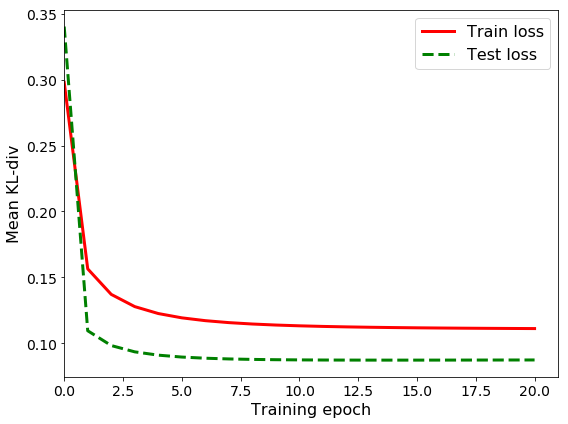

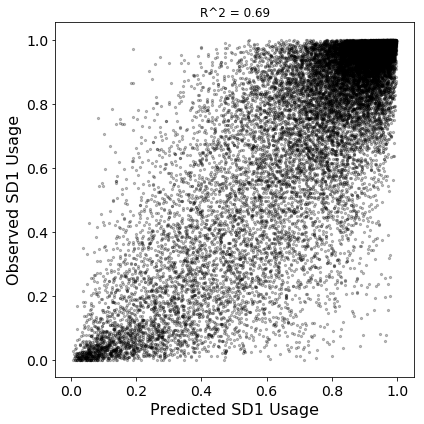

In [10]:
f = plt.figure(figsize=(8, 6))

l1, = plt.plot(np.arange(len(train_losses)), train_losses, linewidth=3, color='red', label='Train loss')
l2, = plt.plot(np.arange(len(train_losses)), test_losses, linewidth=3, color='green', linestyle='--', label='Test loss')

plt.xlabel('Training epoch', fontsize=16)
plt.ylabel('Mean KL-div', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, len(train_losses))

plt.legend(handles=[l1, l2], fontsize=16)

plt.tight_layout()
plt.show()

#TODO: Scatter plot of true vs. pred SD1 usage on test set, and print R^2 coefficient.

y_pred_test = get_y_pred(X_test, w, w_0)

r_val, _ = pearsonr(y_pred_test, y_test)

f = plt.figure(figsize=(6, 6))

plt.scatter(y_pred_test, y_test, s=5, alpha=0.25, c='black')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted SD1 Usage', fontsize=16)
plt.ylabel('Observed SD1 Usage', fontsize=16)

plt.title('R^2 = ' + str(round(r_val * r_val, 2)))

plt.tight_layout()
plt.show()


In [13]:
#Store trained weights

#np.save('simple_position_nmer_weights', w)
np.save('doubledope_position_nmer_weights', w)